# Reinforcement Learning for PG
В данном проекте попробуем написать базовую модель для обучения с подкреплением. Пока мы не будем использовать кастомные фичи среды. А за базовую архитектуру будем испльзовать LSTM, так как модели построенные на данной архитектуре могут использовать память и учитывать ранее произошедшие события.
Анализировать будем акции PG

In [1]:
# Добавим библиотеки для создания среды обучения
import gym
import gym_anytrading

# Добавим библиотеки для алгоритмов RL
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

# Добави базовые библиотеки для обработки и визуализации
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/erick/anaconda3/envs/tf/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


# 1. Подготовка данных

In [2]:
# Читаем данные
df = pd.read_csv("pg.us.txt", parse_dates=["Date"])

In [3]:
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1970-01-02,1.3715,1.3796,1.3715,1.3796,1031284,0
1,1970-01-05,1.3796,1.3875,1.3715,1.3875,642565,0
2,1970-01-06,1.3796,1.3796,1.3715,1.3796,594971,0
3,1970-01-07,1.3796,1.4039,1.3796,1.4039,880559,0
4,1970-01-08,1.4039,1.4198,1.3956,1.4198,658435,0
...,...,...,...,...,...,...,...
12070,2017-11-06,86.5500,86.6400,86.0300,86.0500,5186619,0
12071,2017-11-07,86.0400,87.0000,85.4200,86.9800,6874114,0
12072,2017-11-08,86.9900,87.6000,86.8000,87.5800,6906479,0
12073,2017-11-09,87.3500,88.1698,87.3000,87.7800,5279965,0


Для использования выбранных библиотек важно использование даты, поэтому нам необходима дату перевести в формат datetime, а так же использовать дату в качестве индекса

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date       datetime64[ns]
Open              float64
High              float64
Low               float64
Close             float64
Volume              int64
OpenInt             int64
dtype: object

In [5]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1970-01-02,1.3715,1.3796,1.3715,1.3796,1031284,0
1970-01-05,1.3796,1.3875,1.3715,1.3875,642565,0
1970-01-06,1.3796,1.3796,1.3715,1.3796,594971,0
1970-01-07,1.3796,1.4039,1.3796,1.4039,880559,0
1970-01-08,1.4039,1.4198,1.3956,1.4198,658435,0


Так как открытый интерес всегда пустой - выбросим его из выборки.

In [6]:
df = df.drop("OpenInt", axis=1)

In [7]:
df.shape

(12075, 5)

# 2. Готовим среду

Итак, у нас 12075 торговых дней. В этот преиод компания пережила всевозможные взлеты и падения. Кризисы и бурно-растущие времена. В качесте тренировочной среды мы будем использовать 75% дней. А тестировать будем на оставшихся 25%. В качетстве окна мы возьмем диапахон 5 дней. Так как фактически одна рабочая неделя на бирже - 5 дней. В отличае от криптовалют, акции торгуются с понедельника по пятницу.

In [8]:
# Создаем константы
WEEK = 5
TRAIN = int(len(df)*.75)

In [9]:
# Создаем среду
env = gym.make('stocks-v0', df=df, frame_bound=(WEEK,TRAIN), window_size=WEEK)

In [10]:
# Проверим изменения среды
env.signal_features

array([[ 1.3796e+00,  0.0000e+00],
       [ 1.3875e+00,  7.9000e-03],
       [ 1.3796e+00, -7.9000e-03],
       ...,
       [ 4.5479e+01,  3.0100e-01],
       [ 4.5479e+01,  0.0000e+00],
       [ 4.5114e+01, -3.6500e-01]])

In [11]:
# Проверяем действия агента (их должно быть 2: покупка или продажа)
env.action_space

Discrete(2)

info {'total_reward': 22.48829999999998, 'total_profit': 2.2959516543732602e-14, 'position': 0}


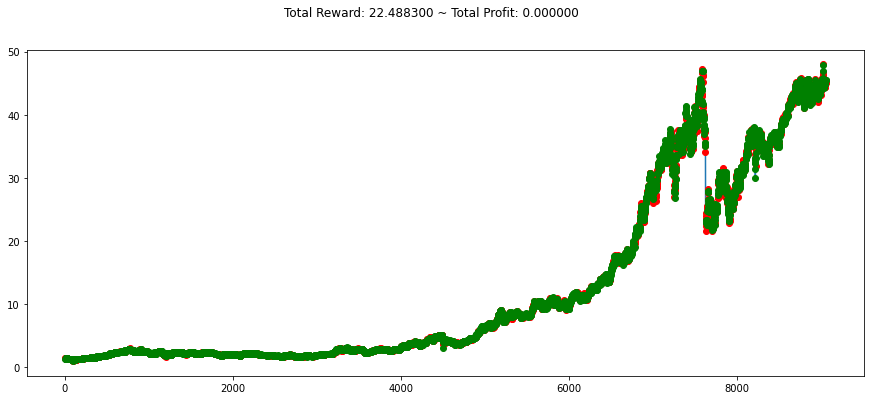

In [12]:
# Запускаем агента в среде со случайным порядком действий
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

Супер, моделька слила депозит. Хотя по факту можно было купить и держать и заработали бы больше 5000% процентов. 
В следующей главе мы будем обучать модель и тестировать её на тестовых данных.

# 3. Тренировка и тестирование
Я умышленно буду останавливать тренировку в ручную. 
Мы должны стремиться получить модель у которой:

1) explain_variance - будет стремиться к 1. 

2) value_loss - стремиться к 0

In [14]:
# Создаем среду
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(WEEK,TRAIN), window_size=WEEK)
env = DummyVecEnv([env_maker])

In [15]:
# Создаем модель и тренируем её
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=1000000)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | -6.4     |
| fps                | 6        |
| nupdates           | 1        |
| policy_entropy     | 0.691    |
| total_timesteps    | 5        |
| value_loss         | 0.000337 |
---------------------------------
---------------------------------
| explained_variance | -0.403   |
| fps                | 108      |
| nupdates           | 100      |
| policy_entropy     | 0.69     |
| total_timesteps    | 500      |
| value_loss         | 3.37e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.165    |
| fps                | 117     

---------------------------------
| explained_variance | -0.0463  |
| fps                | 134      |
| nupdates           | 1600     |
| policy_entropy     | 0.605    |
| total_timesteps    | 8000     |
| value_loss         | 0.308    |
---------------------------------
---------------------------------
| explained_variance | -0.271   |
| fps                | 134      |
| nupdates           | 1700     |
| policy_entropy     | 0.579    |
| total_timesteps    | 8500     |
| value_loss         | 8.57e-05 |
---------------------------------
---------------------------------
| explained_variance | -5.42    |
| fps                | 134      |
| nupdates           | 1800     |
| policy_entropy     | 0.604    |
| total_timesteps    | 9000     |
| value_loss         | 0.00016  |
---------------------------------
---------------------------------
| explained_variance | -5.23    |
| fps                | 134      |
| nupdates           | 1900     |
| policy_entropy     | 0.676    |
| total_timest

---------------------------------
| explained_variance | -0.0498  |
| fps                | 137      |
| nupdates           | 4700     |
| policy_entropy     | 0.693    |
| total_timesteps    | 23500    |
| value_loss         | 8.17e-06 |
---------------------------------
---------------------------------
| explained_variance | 0.00876  |
| fps                | 137      |
| nupdates           | 4800     |
| policy_entropy     | 0.692    |
| total_timesteps    | 24000    |
| value_loss         | 0.00696  |
---------------------------------
---------------------------------
| explained_variance | 0.304    |
| fps                | 137      |
| nupdates           | 4900     |
| policy_entropy     | 0.692    |
| total_timesteps    | 24500    |
| value_loss         | 0.000186 |
---------------------------------
---------------------------------
| explained_variance | 0.0272   |
| fps                | 137      |
| nupdates           | 5000     |
| policy_entropy     | 0.635    |
| total_timest

---------------------------------
| explained_variance | -0.13    |
| fps                | 136      |
| nupdates           | 7800     |
| policy_entropy     | 0.693    |
| total_timesteps    | 39000    |
| value_loss         | 0.000836 |
---------------------------------
---------------------------------
| explained_variance | -0.388   |
| fps                | 136      |
| nupdates           | 7900     |
| policy_entropy     | 0.692    |
| total_timesteps    | 39500    |
| value_loss         | 4.02e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.062   |
| fps                | 136      |
| nupdates           | 8000     |
| policy_entropy     | 0.693    |
| total_timesteps    | 40000    |
| value_loss         | 0.00599  |
---------------------------------
---------------------------------
| explained_variance | -0.114   |
| fps                | 136      |
| nupdates           | 8100     |
| policy_entropy     | 0.693    |
| total_timest

---------------------------------
| explained_variance | -0.0926  |
| fps                | 136      |
| nupdates           | 10900    |
| policy_entropy     | 0.693    |
| total_timesteps    | 54500    |
| value_loss         | 0.000117 |
---------------------------------
---------------------------------
| explained_variance | -0.234   |
| fps                | 136      |
| nupdates           | 11000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 55000    |
| value_loss         | 0.000348 |
---------------------------------
---------------------------------
| explained_variance | -2.46    |
| fps                | 136      |
| nupdates           | 11100    |
| policy_entropy     | 0.693    |
| total_timesteps    | 55500    |
| value_loss         | 3.51e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.662   |
| fps                | 136      |
| nupdates           | 11200    |
| policy_entropy     | 0.693    |
| total_timest

---------------------------------
| explained_variance | -0.0692  |
| fps                | 136      |
| nupdates           | 14000    |
| policy_entropy     | 0.677    |
| total_timesteps    | 70000    |
| value_loss         | 0.00474  |
---------------------------------
---------------------------------
| explained_variance | -0.0258  |
| fps                | 136      |
| nupdates           | 14100    |
| policy_entropy     | 0.672    |
| total_timesteps    | 70500    |
| value_loss         | 0.722    |
---------------------------------
---------------------------------
| explained_variance | -10.6    |
| fps                | 136      |
| nupdates           | 14200    |
| policy_entropy     | 0.691    |
| total_timesteps    | 71000    |
| value_loss         | 0.00139  |
---------------------------------
---------------------------------
| explained_variance | 0.0216   |
| fps                | 136      |
| nupdates           | 14300    |
| policy_entropy     | 0.685    |
| total_timest

KeyboardInterrupt: 

Я умышлено остановил на explained_variance 0.442. Модель может объяснить 44% Дисперсии. Данный результат большая редкость за все количество наблюдений. Видимо без кастомных фичей продолжать обучение на исходных данных - бесполезно.

In [16]:
# Попробуем  использовать модель
env = gym.make('stocks-v0', df=df, frame_bound=(TRAIN-WEEK,len(df)), window_size=WEEK)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 35.52899999999989, 'total_profit': 1.92949850601386e-05, 'position': 0}


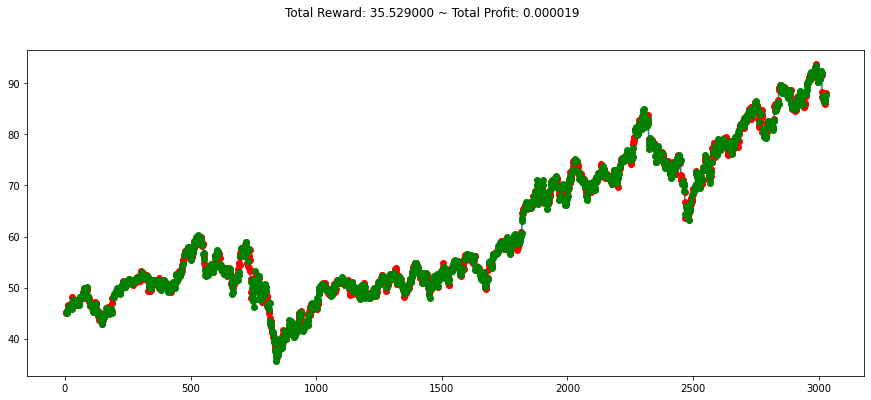

In [17]:
# Визуализируем
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# Вывод:

Наша модель показала микро+. Это уже лучше большинства спекулянтов (как известно, большинство все таки теряют). Данную модель можно улучшить, используя кастомные фичи среды, а так же дорабатываю архитектуру самой модели. Этим займемся в следующих исследованиях.